In [72]:
from library import *
from dataset_creation import *

In [2]:
def plot_color(values, size=(30,5), coef=1):
    
    my_cmap = plt.get_cmap('copper')
    my_norm = plt.Normalize(vmin=0, vmax=max(values)*coef)
    colormap=my_cmap(my_norm(values))
    
    return colormap

In [68]:
def plot_line(x, y):    
    fig, ax = plt.subplots(1,1,figsize=(15,15), facecolor="k")

    ax.plot(x, y, color="gold", linewidth=4, marker = "o", linestyle="--", markerfacecolor="darkorange", markersize=15)

    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')

    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xticks(size = 20)
    plt.yticks(size = 20)

    ax.grid(color="lightgray", alpha = 0.2)

In [ ]:
accuracies = []

for k in tqdm([5, 25, 50]):
    
    f_scores = []
    
    for f in tqdm(range(3,17)):

        kfold = KFold(n_splits=10, random_state=123, shuffle=True)

        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

        sfs_kn = sfs(estimator = model, n_features_to_select=f, cv=kfold, n_jobs=-1)

        sfs_kn.fit(X_res, y_res)

        temp_X_res = sfs_kn.transform(X_res)
        
        scores = cross_val_score(model, temp_X_res, y_res, scoring='accuracy', cv=kfold, n_jobs=-1)
        
        f_scores.append((mean(scores), f))      
    
    accuracies.append([k, max(f_scores, key=lambda e: e[0])[0], max(f_scores, key=lambda e: e[0])[1]])
        
        

In [27]:
accuracies

[[4, 0.8547326906222612, 11], [40, 0.8341539208202576, 11]]

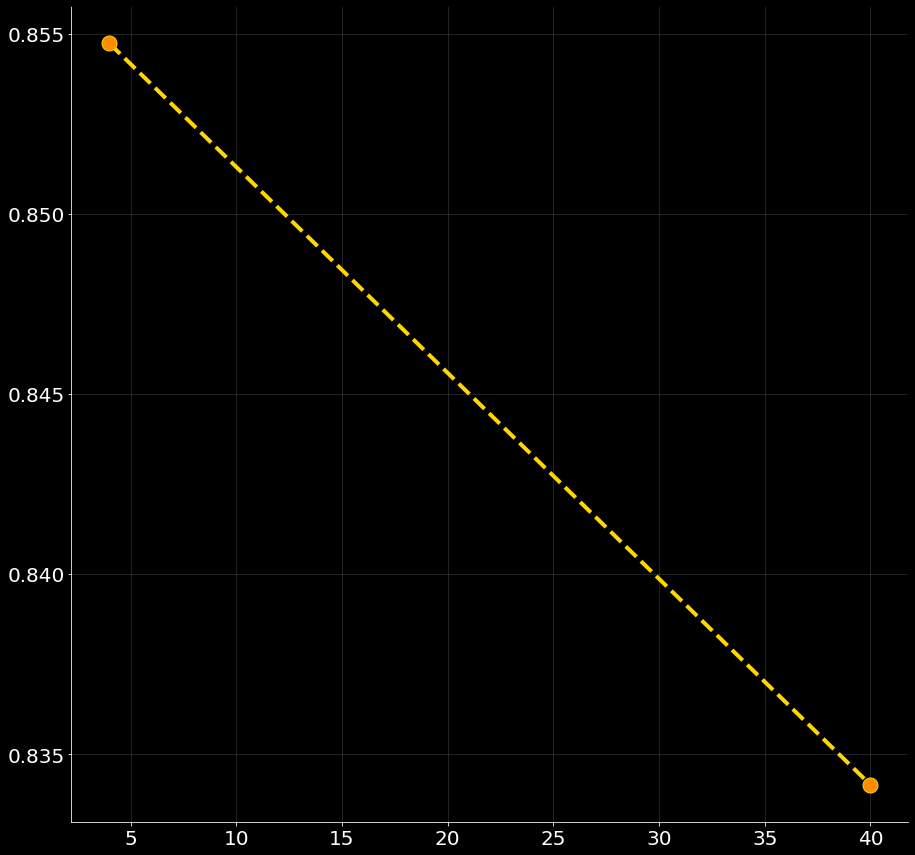

In [69]:
plot_line([el[0] for el in accuracies],[el[1] for el in accuracies])

# Logistic Regression

In [ ]:
accuracies = []

for degree in tqdm(range(1,5)):
    
    c_scores = []
    
    for c in [0.01,0.1,1,10,100]:
    
        f_scores = []
    
        for f in range(3,17):

            kfold = KFold(n_splits=10, random_state=123, shuffle=True)

            model = LogisticRegression(solver="newton-cg", n_jobs=-1)

            sfs_kn = sfs(estimator = model, n_features_to_select=f, cv=kfold, n_jobs=-1)
            
            poly = PolynomialFeatures(degree = degree, interaction_only=False, include_bias=False)
            
            X_res_poly = poly.fit_transform(X_res)

            sfs_kn.fit(X_res_poly, y_res)

            temp_X_res_poly = sfs_kn.transform(X_res)

            scores = cross_val_score(model, temp_X_res_poly, y_res, scoring='accuracy', cv=kfold, n_jobs=-1)

            f_scores.append((mean(scores), f))      
    
        c_scores.append([c, max(f_scores, key=lambda e: e[0])[0], max(f_scores, key=lambda e: e[0])[1]])
        
    accuracies.append([degree, max(c_scores, key=lambda e: e[0])[0], max(c_scores, key=lambda e: e[0])[2], max(c_scores, key=lambda e: e[0])[1]])